# Unsupervised Learning 1 - Classification
### * K-means & DBSCAN
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
from sklearn.decomposition import PCA, NMF
from sklearn.externals.joblib import Memory

memory = Memory(cachedir="cache")

cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

@memory.cache
def pca_faces(X_train, X_test):
    # copy and pasted from nmf. refactor?
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = pca_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500, 2000]):
        ax.set_title("Component = %d" % n_components)


def nmf_faces(X_train, X_test):
    # Build NMF models with 10, 50, 100 and 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        nmf = NMF(n_components=n_components, random_state=0)
        nmf.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_nmf = nmf.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = np.dot(X_test_nmf, nmf.components_)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_nmf_faces(X_train, X_test, image_shape):
    reduced_images = nmf_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("Component = %d" % n_components)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  


# 1. Kmeans Classification without Scikit-Learn

In [0]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

## (1) 데이터 준비

In [20]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

print(len(X), len(y))
print(X[:10], y[:10])

100 100
[[ -0.79415228   2.10495117]
 [ -9.15155186  -4.81286449]
 [-11.44182631  -4.45781441]
 [ -9.76761777  -3.19133737]
 [ -4.53655648  -8.40186288]
 [ -6.26302115  -8.10666081]
 [ -6.38481234  -8.4730297 ]
 [ -9.20490564  -4.57687928]
 [ -2.76017908   5.55121358]
 [ -1.17104176   4.33091816]] [0 1 1 1 2 2 2 1 0 0]


### X, y를 그림으로 나타내면 다음과 같습니다.

(-15.880540867189191, 11.799220003780011)

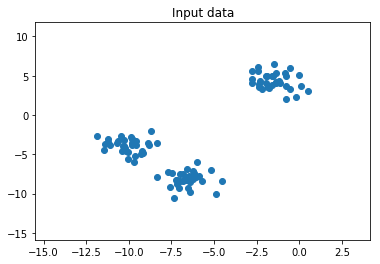

In [21]:
#for visulalization
ax = plt.gca()
ax.set_title("Input data")
ax.plot(X[:,0], X[:,1], 'o')

ax.set_xlim(X[:,0].min() - X[:,0].std(), X[:,0].max() + X[:,0].std())
ax.set_ylim(X[:,1].min() - X[:,1].std(), X[:,1].max() + X[:,1].std())

## (2) K-means Algorithm

### 1) 데이터의 어떤 영역을 대표하는 클러스터 중심(cluster center)을 정한다.

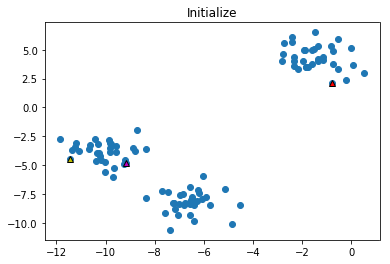

In [22]:
center = X[:3, :] #클러스터 중심을 입력 데이터의 점으로 선택합니다.

#for visulalization
ax = plt.gca()
ax.set_title("Initialize")
ax.plot(X[:,0], X[:,1], 'o')

ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 2) 데이터를 가장 가까운 클러스터 중심에 할당한다.

[0 1 2 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 1 1 1
 2 1 1 1 1 0 2 1 1 0 0 0 0 1 1 1 1 0 1 2 1 0 0 1 1 1 1 2 1 0 1 0 1 1 1 1 0
 0 1 1 1 0 2 0 2 1 1 0 0 0 0 2 0 1 0 0 2 1 1 1 0 1 0]


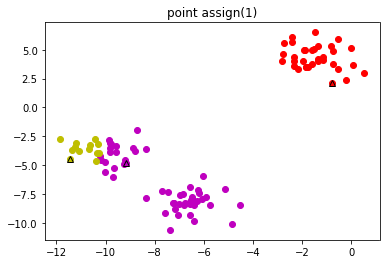

In [23]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)

#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(1)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 3) 할당된 데이터 포인트의 평균으로 클러스터 중심을 다시 정한다.

[[ -1.4710815    4.33721882]
 [ -7.69121704  -6.61992423]
 [-10.86146665  -3.5536807 ]]


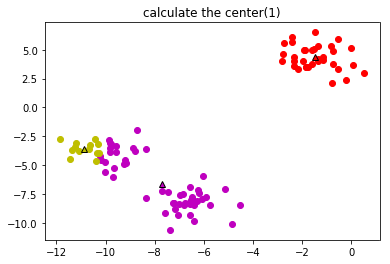

In [24]:
center = [X[np.where(labels == i)].mean(axis=0) for i in range(3)]
# 풀어쓰면 다음과 같습니다.
for i in range(3):
    indices = np.where(labels==i)
    center[i] = X[indices].mean(axis=0)

center = np.array(center)
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(1)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 4) 2), 3)의 과정(데이터 할당, 클러스터 중심 계산)을 반복한다.

[0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 1 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


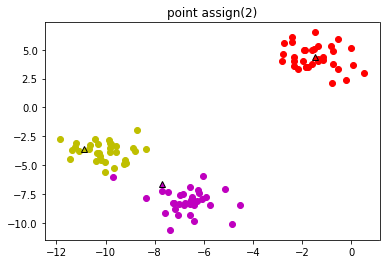

In [25]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)

#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(2)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

[[ -1.4710815    4.33721882]
 [ -6.67314756  -8.10778035]
 [-10.06082976  -3.79341568]]


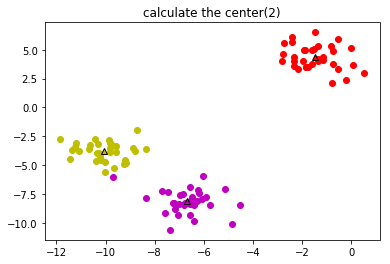

In [26]:
center = np.array([np.mean(x, axis=0) for x in X_labels])
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(2)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

[0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 2 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


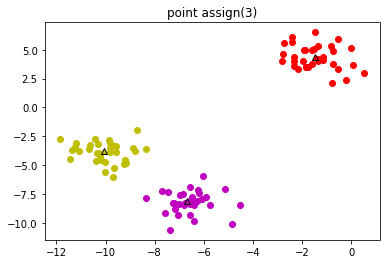

In [27]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)


#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(3)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

[[ -1.4710815    4.33721882]
 [ -6.58196786  -8.17239339]
 [-10.04935243  -3.85954095]]


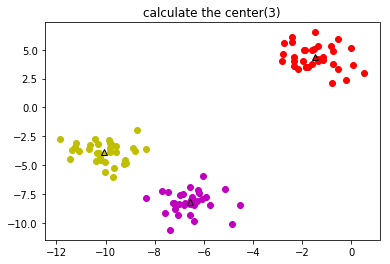

In [28]:
center = np.array([np.mean(x, axis=0) for x in X_labels])
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(3)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

[0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 2 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


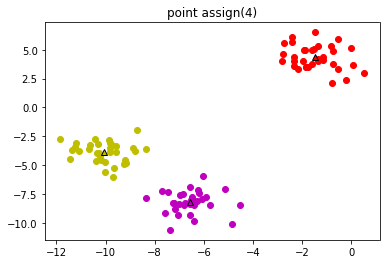

In [29]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)


#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(4)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

# 2. Kmeans Classification with Scikit-Learn

In [0]:
from sklearn.cluster import KMeans

## (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

## (2) K-Means 알고리즘 실행

In [32]:
# 군집 모델을 만듭니다
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## (3) 실행결과 확인

In [33]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[1 0 0 0 2 2 2 0 1 1 0 0 2 1 2 2 2 1 0 0 2 0 2 1 0 2 2 1 1 2 1 1 2 1 0 2 0
 0 0 2 2 0 1 0 0 2 1 1 1 1 0 2 2 2 1 2 0 0 1 1 0 2 2 0 0 2 1 2 1 0 0 0 2 1
 1 0 2 2 1 0 1 0 0 2 1 1 1 1 0 1 2 1 1 0 0 2 2 1 2 1]
[[-10.04935243  -3.85954095]
 [ -1.4710815    4.33721882]
 [ -6.58196786  -8.17239339]]


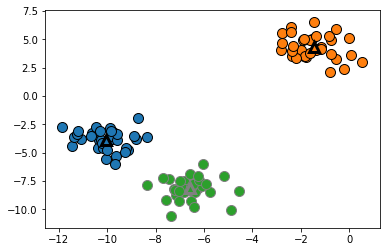

In [35]:
# 데이터를 그래프로 표현하기 위한 함수입니다.
# def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None, labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None)
# x1 : input data, first axis
# x2 : input data, sexond axis
# y : input data, discrete labels

discrete_scatter(X[:,0],X[:,1], kmeans.labels_, markers='o')
discrete_scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],[0,1,2], markers='^', markeredgewidth=3)

## (4) 실습

### 위의 예시를 참고해서, X, y를 적절히 분류해보세요

In [0]:
X, y = make_blobs(centers=4, random_state=6)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

# 3. DBSCAN with Scikit-Learn

In [0]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

## (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

## (2) DBSCAN 알고리즘 실행

In [0]:
dbscan = DBSCAN()
dbscan.fit(X)

## (3) 실행결과 확인

In [0]:
print(dbscan.labels_)

In [0]:
discrete_scatter(X[:,0],X[:,1], dbscan.labels_)

## (4) 실습

### DBSCAN의 파라미터(eps, min_samples)를 조정하여 데이터를 적절히 분류해보세요.
#### ex. dbscan = DBSCAN(eps=0.5, min_samples=5)

In [0]:
X, y = make_blobs(random_state = 1)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

### DBSCAN의 파라미터(eps, min_samples)를 조정하여 데이터를 적절히 분류해보세요.
#### ex. dbscan = DBSCAN(eps=0.5, min_samples=5)

In [0]:
from sklearn.datasets import make_circles
X, y = make_circles()

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

# Unsupervised Learning 2 - Dimensionality Reduction
### * PCA & NMF
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

## (1) 데이터 준비

In [0]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [0]:
print(lfw_people.data.shape) 
print(lfw_people.images.shape) 
print(lfw_people.target.shape)
print(len(lfw_people.target_names))

In [0]:
import numpy as np
lfw_counts = np.bincount(lfw_people.target) # 각 클래스별 빈도 계산
for (name, count) in zip(lfw_people.target_names, lfw_counts):
    print("{0:25} {1:4}".format(name, count)) # (이름, 빈도 수) 출력

In [0]:
mask = np.zeros(lfw_people.target.shape, dtype=np.bool)
for target in np.unique(lfw_people.target):
    mask[np.where(lfw_people.target==target)[0][:50]] = True

X_people = lfw_people.data[mask]
y_people = lfw_people.target[mask]
X_people = X_people/255	 # 픽셀 크기를 0~1 사이로 조정
print(X_people.shape) # output = (2063, 5655)
print(y_people.shape) # output = (2063,)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

## (2) PCA 알고리즘 실행

In [0]:
from sklearn.decomposition import PCA
pca=PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train) # X_train에 차원축소 방법인 PCA 적용 
X_test_pca = pca.transform(X_test) # X_test에 차원축소 방법인 PCA 적용 
print(X_train_pca.shape)
print(X_test_pca.shape)
X_train_back = pca.inverse_transform(X_train_pca) # X_train_pca를 원래 데이터로 복구 
X_test_back = pca.inverse_transform(X_test_pca) # X_test_pca를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

## (3) 실행결과 확인

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})

image_shape = lfw_people.images[0].shape	 # output = (87, 65)

for i, (component, ax) in enumerate(zip(pca.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("PCA {}".format((i+1)))

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [0]:
import mglearn
mglearn.plot_pca_faces(X_train, X_test, image_shape)

## (2) NMF 알고리즘 실행

In [0]:
from sklearn.decomposition import NMF
nmf=NMF(n_components=100, random_state=0).fit(X_train)
X_train_nmf = nmf.transform(X_train) # X_train에 차원축소 방법인 NMF 적용 
X_test_nmf = nmf.transform(X_test) # X_test에 차원축소 방법인 NMF 적용 
print(X_train_nmf.shape)
print(X_test_nmf.shape)
X_train_back = nmf.inverse_transform(X_train_nmf) # X_train_nmf를 원래 데이터로 복구 
X_test_back = nmf.inverse_transform(X_test_nmf) # X_test_nmf를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

## (3) 실행결과 확인

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("NMF {}".format((i+1)))

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [0]:
import mglearn
mglearn.plot_nmf_faces(X_train, X_test, image_shape) # time: 8.8min

## 종합

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': (), 'yticks':()})
for ax, fe_pca, fe_nmf in zip(axes.T, pca.components_, nmf.components_):
    ax[0].imshow(fe_pca.reshape(image_shape))
    ax[1].imshow(fe_nmf.reshape(image_shape))

axes[0,0].set_ylabel("PCA")
axes[1,0].set_ylabel("NMF")

In [0]:
X_reconstructed_pca=pca.inverse_transform(pca.transform(X_test))
X_reconstructed_nmf=np.dot(nmf.transform(X_test), nmf.components_)
fig, axes=plt.subplots(3, 5, figsize=(10, 8), subplot_kw={'xticks': (),'yticks':()})
for ax, ori, ir_pca, ir_nmf in zip(axes.T, X_test, X_reconstructed_pca,X_reconstructed_nmf):
    ax[0].imshow(ori.reshape(image_shape))
    ax[1].imshow(ir_pca.reshape(image_shape))
    ax[2].imshow(ir_nmf.reshape(image_shape))

axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("PCA")
axes[2,0].set_ylabel("NMF")

# TensorFlow Tutorial

In [0]:
import tensorflow as tf

## Data Flow Graphs

In [0]:
a = tf.add(3, 5)
print(a)

In [0]:
sess = tf.Session()
print(sess.run(a))    # 8
sess.close()  # 더 이상 필요하지 않은 자원을 할당 해제

In [0]:
with tf.Session() as sess:
    print(sess.run(a))    # 8

## Constants & Operations

In [0]:
a = tf.constant([2, 2])
b = tf.constant([[0, 1], [2, 3]])
x = tf.add(a, b)
y = tf.multiply(a, b)
with tf.Session() as sess:
    x, y = sess.run([x, y])
    print(x)
    print(y)

## 실습

### 텐서플로우의 상수와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [0]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.










#-----------------------------------------------------
print(val1)
print(val2)
print(val3)

## Variables

In [0]:
W = tf.Variable(10)
assign_op = W.assign(100)
with tf.Session() as sess:
    sess.run(assign_op)
    print(W.eval())

## 실습

### 텐서플로우의 변수와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [0]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
print(val1)
print(val2)
print(val3)

## Placeholder

In [0]:
a = tf.placeholder(tf.float32, shape=[3])
b = tf.constant([5, 5, 5], tf.float32)
c = a + b # tf.add(a, b) 와 같다.
with tf.Session() as sess:
    print(sess.run(c, feed_dict={a: [1, 2, 3]}))

## 실습

### 텐서플로의 플레이스홀더와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [0]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
print(val1)
print(val2)
print(val3)